In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from hmmlearn import hmm  
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load the data
data = pd.read_csv("salesdata.csv")

In [7]:
print(data.head)
print(data.tail) 

<bound method NDFrame.head of         record_ID      week  store_id  sku_id  total_price  base_price  \
0               1  17/01/11      8091  216418      99.0375    111.8625   
1               2  17/01/11      8091  216419      99.0375     99.0375   
2               3  17/01/11      8091  216425     133.9500    133.9500   
3               4  17/01/11      8091  216233     133.9500    133.9500   
4               5  17/01/11      8091  217390     141.0750    141.0750   
...           ...       ...       ...     ...          ...         ...   
150145     212638  09/07/13      9984  223245     235.8375    235.8375   
150146     212639  09/07/13      9984  223153     235.8375    235.8375   
150147     212642  09/07/13      9984  245338     357.6750    483.7875   
150148     212643  09/07/13      9984  547934     141.7875    191.6625   
150149     212644  09/07/13      9984  679023     234.4125    234.4125   

        is_featured_sku  is_display_sku  units_sold  
0                     0    

In [8]:
data.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [9]:
# Feature engineering
data['week'] = pd.to_datetime(data['week'])
data['day'] = data['week'].dt.day
data['month'] = data['week'].dt.month
data['year'] = data['week'].dt.year

C:\Users\Hemanth Gowda N\AppData\Local\Temp\ipykernel_20700\2883993337.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['week'] = pd.to_datetime(data['week'])


In [10]:
print(data.columns)

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold', 'day', 'month',
       'year'],
      dtype='object')


In [11]:
# Drop unnecessary columns
data = data.drop(['record_ID', 'week'], axis=1)

In [12]:
# Split the data into features (X) and target variable (y)
X = data.drop('units_sold', axis=1)
y = data['units_sold']

In [14]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day,month,year
147346,9456,216419,86.9250,86.9250,0,0,25,6,2013
20252,9425,216419,84.0750,84.0750,0,0,16,5,2011
29262,9112,219009,224.4375,224.4375,0,0,7,11,2011
73300,9281,216418,85.5000,85.5000,0,0,4,3,2012
83910,9532,398721,469.5375,469.5375,0,0,6,5,2012
...,...,...,...,...,...,...,...,...,...
119879,9789,547934,170.2875,170.2875,0,0,1,8,2013
103694,9770,245387,355.5375,469.5375,0,0,10,2,2012
131932,8555,216418,69.8250,88.3500,0,0,26,3,2013
146867,8319,222765,177.4125,239.4000,1,1,25,6,2013


In [21]:
X_test

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day,month,year
144782,9132,223153,212.3250,212.3250,0,0,6,11,2013
117,8222,378934,205.9125,205.9125,0,0,17,1,2011
77408,8095,223153,140.3625,227.2875,1,1,5,1,2012
62193,9809,245338,498.0375,498.0375,0,0,23,1,2012
143901,9479,217777,237.9750,237.9750,0,0,6,4,2013
...,...,...,...,...,...,...,...,...,...
146710,8095,245338,469.5375,469.5375,0,0,25,6,2013
55307,9876,219009,195.9375,227.2875,0,0,12,12,2011
119838,9745,216418,109.0125,109.0125,0,0,1,8,2013
102935,8121,245387,354.1125,469.5375,0,0,10,2,2012


In [22]:
y_train

147346     14
20252      39
29262     143
73300      31
83910       2
         ... 
119879     28
103694     13
131932     23
146867     84
121958     78
Name: units_sold, Length: 120120, dtype: int64

In [23]:
y_test

144782     41
117        13
77408     339
62193      14
143901      4
         ... 
146710     17
55307      90
119838    180
102935     17
110483     52
Name: units_sold, Length: 30030, dtype: int64

In [15]:
# Check for missing values
missing_values = X_train.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
day                0
month              0
year               0
dtype: int64


In [16]:
missing_values_test = X_test.isnull().sum()
print("Missing Values in Test Set:")
print(missing_values_test)

Missing Values in Test Set:
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
day                0
month              0
year               0
dtype: int64


In [18]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [113]:
# Define a preprocessor to handle numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [114]:
# Check if X_train is a pandas DataFrame
if isinstance(X_train, pd.DataFrame):
    # Define numeric and categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
else:
    # If X_train is a NumPy array, assume all features are numeric
    numeric_features = range(X_train.shape[1])
    categorical_features = []

In [115]:
# Define a pipeline for numerical feature preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),# Imputation using mean
    ('scaler', StandardScaler())# Standardization of features
])

In [116]:
# Define a pipeline for categorical feature preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [98]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),# Imputation using most frequent value
        ('cat', OneHotEncoder(), categorical_features)# One-hot encoding with handling of unknown categories
])
    ])

In [117]:
# Define models
models = [
    ('XGBoost', XGBRegressor(objective='reg:squarederror')),
    ('Random Forest', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('HMM', hmm.GaussianHMM(n_components=1))
]

XGBoost RMSE: 26.52644533806214


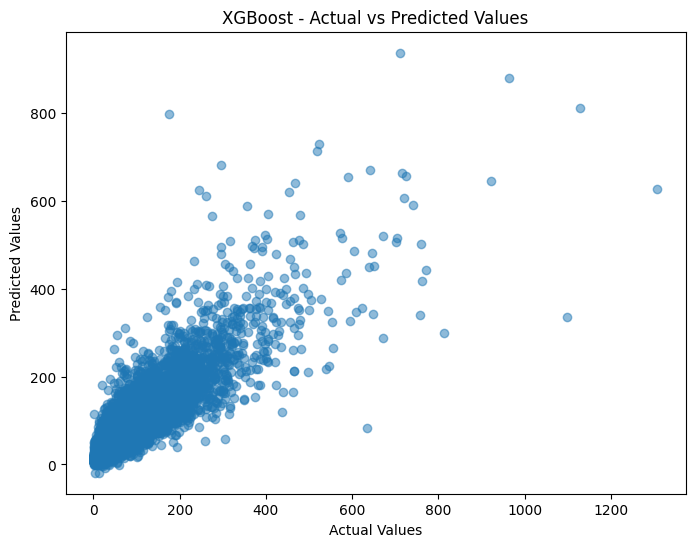

Random Forest RMSE: 26.52644533806214


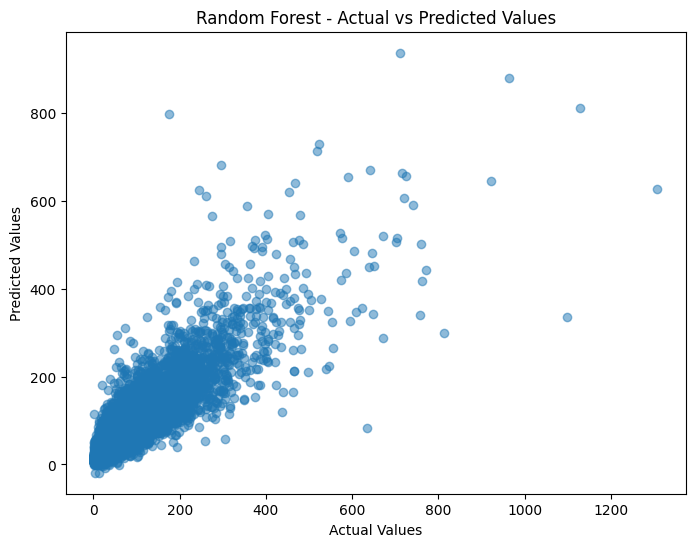

KNN RMSE: 26.52644533806214


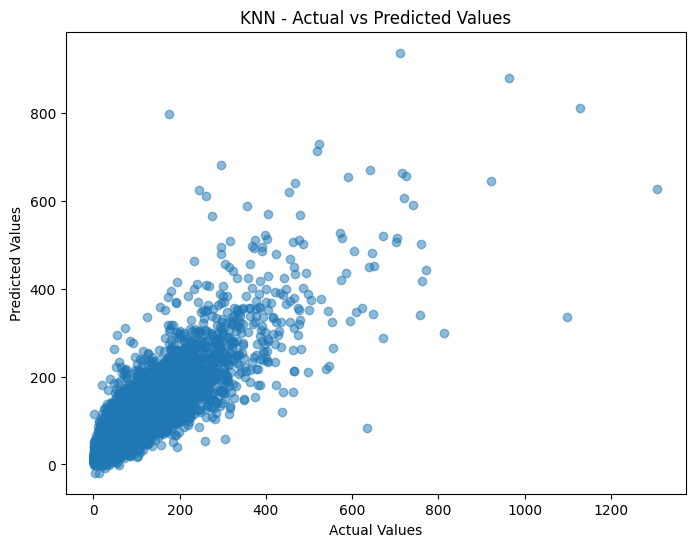

HMM RMSE: 26.52644533806214


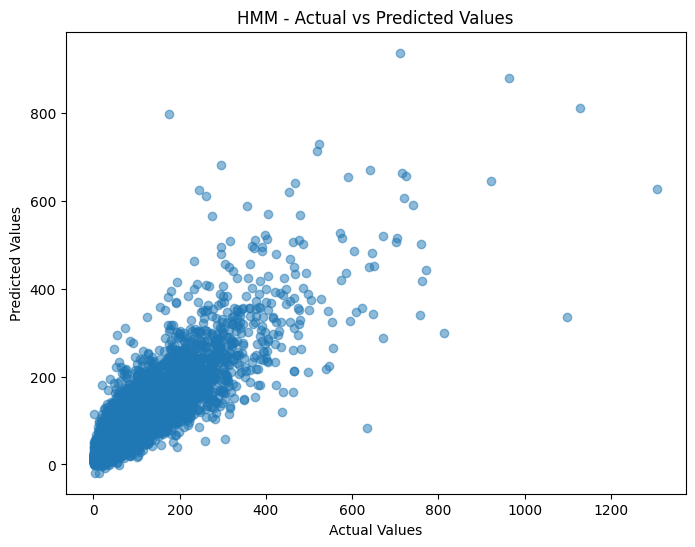

In [118]:
for name, model in models:
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', model)])
    
    
    # Evaluate the model
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'{name} RMSE: {rmse}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title(f'{name} - Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

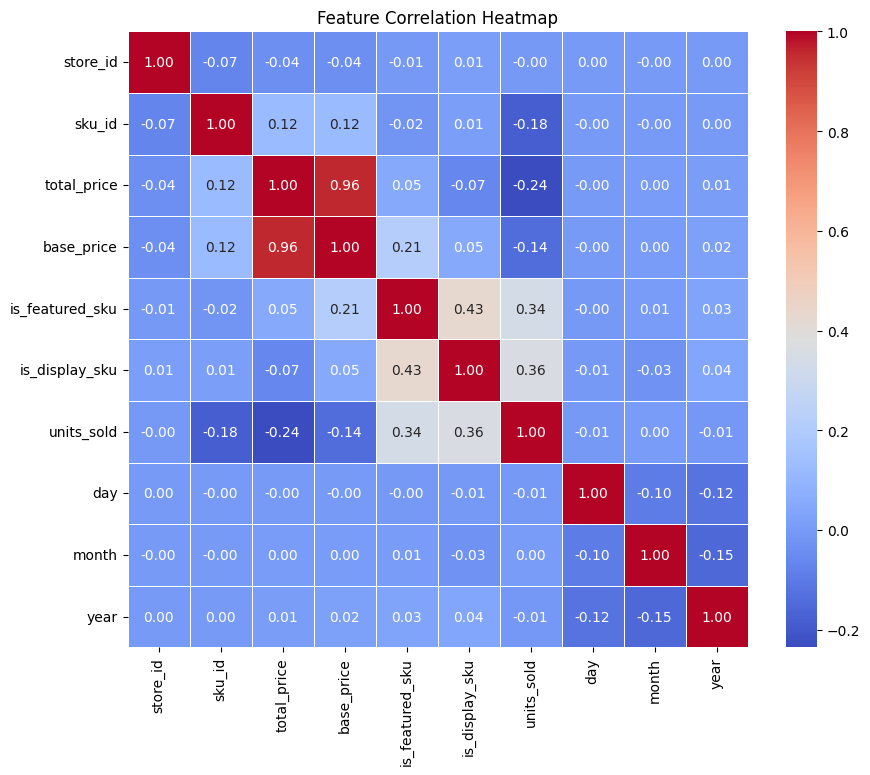

In [35]:
# Create a heatmap to visualize feature correlations
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [12]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 26.52644533806214


In [126]:
pip install hmm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for hmm: filename=hmm-0.0.1-py3-none-any.whl size=1837 sha256=f0eb55b3ff70fb5ae1411c8bb7b5f99d23e79a574b75563e8266f3e7f97a9aa2
  Stored in directory: c:\users\hemanth gowda n\appdata\local\pip\cache\wheels\10\54\54\30d631fdeb5fff45d0b1d18c8d69c9d3fe80f4eb0ebc748f52
Successfully built hmm
Note: you may need to restart the kernel to use updated packages.


Random Forest RMSE: 29.112669593680653
KNN RMSE: 33.269343367809476
HMM RMSE: 76.83723710324965


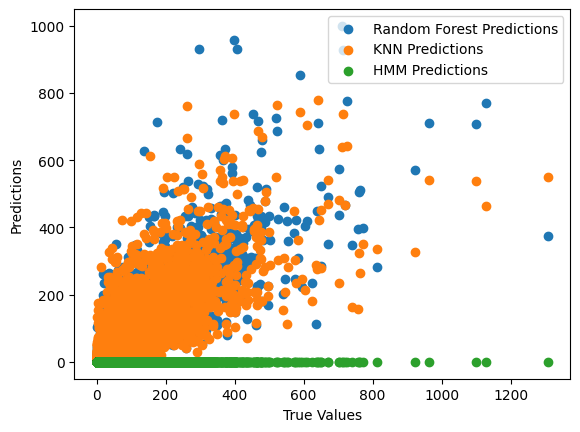

In [131]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from hmmlearn import hmm
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Assuming you have X_train, X_test, y_train, and y_test datasets

# Check if X_train is a pandas DataFrame
if isinstance(X_train, pd.DataFrame):
    # Define numeric and categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
else:
    # If X_train is a NumPy array, assume all features are numeric
    numeric_features = range(X_train.shape[1])
    categorical_features = []

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)
hmm_model = hmm.GaussianHMM(n_components=1)

# Define the full pipeline with the models
full_pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', rf_model)])

full_pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', knn_model)])

full_pipeline_hmm = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', hmm_model)])

# Fit the models
full_pipeline_rf.fit(X_train, y_train)
full_pipeline_knn.fit(X_train, y_train)

# For HMM, lengths parameter needs to be provided
lengths = np.array([len(X_train)])
full_pipeline_hmm.fit(X_train, lengths)

# Make predictions on the test set
y_pred_rf = full_pipeline_rf.predict(X_test)
y_pred_knn = full_pipeline_knn.predict(X_test)

# For HMM, lengths parameter needs to be provided
lengths_test = np.array([len(X_test)])
hmm_predicted_states = full_pipeline_hmm.predict(X_test, lengths=lengths_test)

# The HMM model predicts the states, not the target values directly
# To get the predicted values, we can use the means of the corresponding states
# Extract the means from the underlying HMM model
hmm_means = full_pipeline_hmm.named_steps['regressor'].means_
hmm_predicted_values = np.array([hmm_means[state, 0] for state in hmm_predicted_states])

# Evaluate the models
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_knn = sqrt(mean_squared_error(y_test, y_pred_knn))
rmse_hmm = sqrt(mean_squared_error(y_test, hmm_predicted_values))

print("Random Forest RMSE:", rmse_rf)
print("KNN RMSE:", rmse_knn)
print("HMM RMSE:", rmse_hmm)

# Optionally, you can visualize the predictions
plt.scatter(y_test, y_pred_rf, label='Random Forest Predictions')
plt.scatter(y_test, y_pred_knn, label='KNN Predictions')
plt.scatter(y_test, hmm_predicted_values, label='HMM Predictions')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()
